# Máster Oficial en Investigación en Inteligencia Artificial - Datos temporales y complejos
## Series temporales - Predicción de la demanda eléctica

### Índice
1. Análisis de los datos
2. Preprocesado
3. Modelado
4. Evaluación
5. Conclusiones

### Análisis de los datos

Durante esta parte, se analizarán distintas métricas y visualizaciones de los datos con el objetivo de obtener un mayor conocimiento del problema usar ese conocimiento en el modelado.

In [2]:
import pandas as pd
from pylab import rcParams
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.trainer import Trainer
from gluonts.model.predictor import Predictor

from pathlib import Path
from gluonts.model.predictor import Predictor
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K

from fbprophet import Prophet
import datetime

mx.random.seed(0)
np.random.seed(0)

D:\Programas\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
INFO:root:Using CPU
INFO:root:Using CPU
Using TensorFlow backend.
C:\Users\manue\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\manue\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\manue\AppData\Roa

In [8]:
def mape(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rse(y_true, y_pred):

    num = K.sqrt(K.mean(K.square(K.constant(y_true) - K.constant(y_pred)), axis=None))
    den = K.std(K.constant(y_true), axis=None)
    
    return num / den

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def corr(y_true, y_pred):
    y_true = K.constant(y_true)
    y_pred = K.constant(y_pred)
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

In [3]:
demand = pd.read_excel('Demanda_2015.xlsx', header=None)
demand.columns = ['date', 'time', 'demand']
demand['datetime'] = pd.to_datetime(demand['date'].astype(str)+" "+demand['time'].astype(str), format='%Y-%m-%d %H:%M:%S')
demand.drop(['date', 'time'], inplace=True, axis=1)
demand = demand.set_index('datetime')

En primer lugar se tomará una muestra de los datos para observar el formato que este sigue. 

In [4]:
demand.head(10)

,demand
datetime,
2015-01-01 00:00:00,25459
2015-01-01 00:10:00,25591
2015-01-01 00:20:00,25531
2015-01-01 00:30:00,25453
2015-01-01 00:40:00,25329
2015-01-01 00:50:00,25247
2015-01-01 01:00:00,25093
2015-01-01 01:10:00,24853
2015-01-01 01:20:00,24678


Los datos constan de dos columnas donde la primera denota la fecha (índice)
y el valor de la demanda en el momento indicado por la fecha. Se puede observar que los datos son muestreados con una frecuencia de 10 minutos aparentemente estable, es decir, no presenta discontinuidades temporales como podría presentarlo un Data Stream. 
Por lo tanto, se trata de una serie temporal univariada, en la que la variable a predecir solo dependerá de sus propios valores pasados.

En segundo lugar, se mostrarán una serie de estadísticas sobre los datos que resumirán una serie de estadísticos.

In [22]:
demand.describe()

,demand
count,52560.000000
mean,28348.614212
std,4671.815664
min,17985.000000
25%,24392.000000
50%,28566.000000
75%,31664.000000
max,40648.000000


Existen 52560 ejemplos y no existen valores perdidos de ningún tipo. Los valores de demanda se encuentran en el rango [17985, 40648] y la desviación típica es de 4671,82. Se puede observar como aparentemente no existe algun tipo de outlier destacable ya que el máximo y el mínimo visualizando los cuartiles no presentan un cambio exageradamente grande. Sin embargo, esto es una evaluación subjetiva, en posteriores secciones se analizará con más detalle.

A continuación se mostrarán una serie de gráficas con el objetivo de obtener una mayor intuición de los datos.

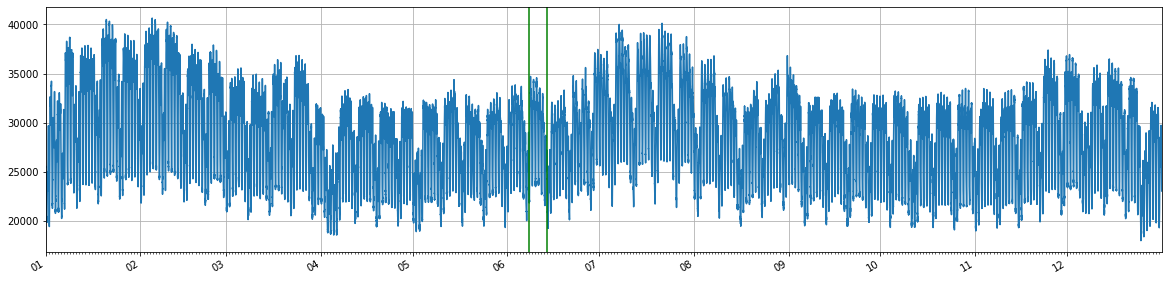

In [27]:
days = mdates.DayLocator()   # every year
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(demand)
ax.axvline(datetime(2015, 6, 8), color='green')
ax.axvline(datetime(2015, 6, 14), color='green')
# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# round to nearest years.
datemin = np.datetime64(demand.index[0], 'm')
datemax = np.datetime64(demand.index[-1], 'm') + np.timedelta64(1, 'm')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

La visualización de toda la serie temporal nos indica que existen ciertas oscilaciones a lo largo del año. Por ejemplo, se muestra que
a poco después del principio, en mitades y poco antes de finales de año existe una mayor demanda. En estos intervalos donde existe una mayor demanda
se corresponden con febrero, mitades de junio y diciembre. Cabe esperar estos picos dado que se correponden con épocas muy frías y muy cálidas. En color verde se muestran dos lineas verdes que representa la zona con los datos a predecir.

A continuación, se analizará la distribución de los datos de la demanda a través de un histograma.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFAA93B6D8>]],
      dtype=object)

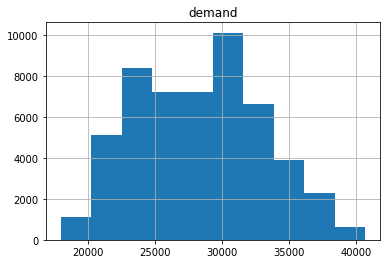

In [28]:
demand.hist()

Como puede observarse los datos siguen una distribución normal donde la media se encuentra alrededor de los 30000 kw.

A continuación, se mostrará una se una descomposición de la serie temporal en sus distintas componentes usando ventanas deslizantes promedios. Para esta representación se ha tomado dos tamaños de ventana posibles, ventanas de tamaño mensual y semanal.

In [33]:
def plot_rolling(df, window_size, title):
    fig, ax = plt.subplots(figsize=(12, 9))
    
    ax.plot(demand)
    ax.plot(demand.index,df.demand.rolling(window=window_size).mean(), label="rolling mean");
    ax.plot(demand.index,df.demand.rolling(window=window_size).std(), label="rolling std");
    ax.legend()

    plt.tight_layout()
    plt.title(title)
    fig.autofmt_xdate()

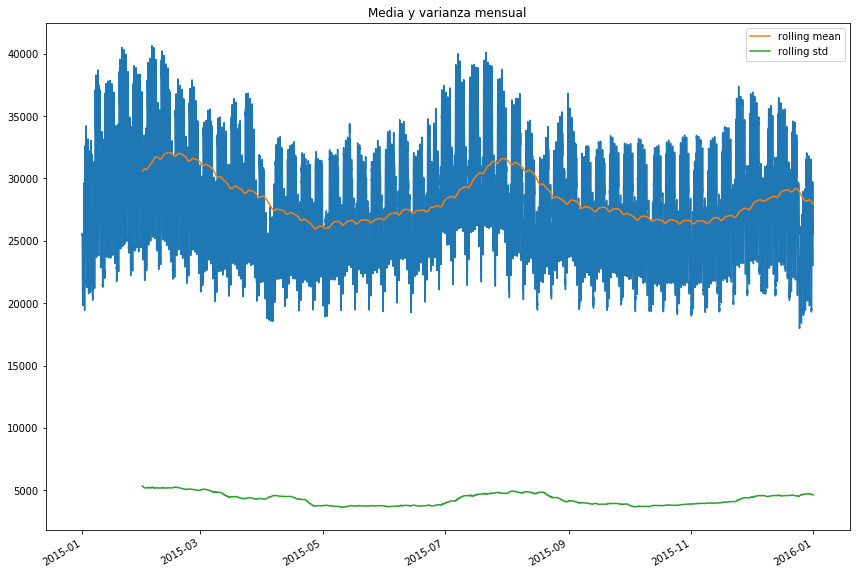

In [34]:
plot_rolling(demand, 30*24*6, "Media y varianza mensual")

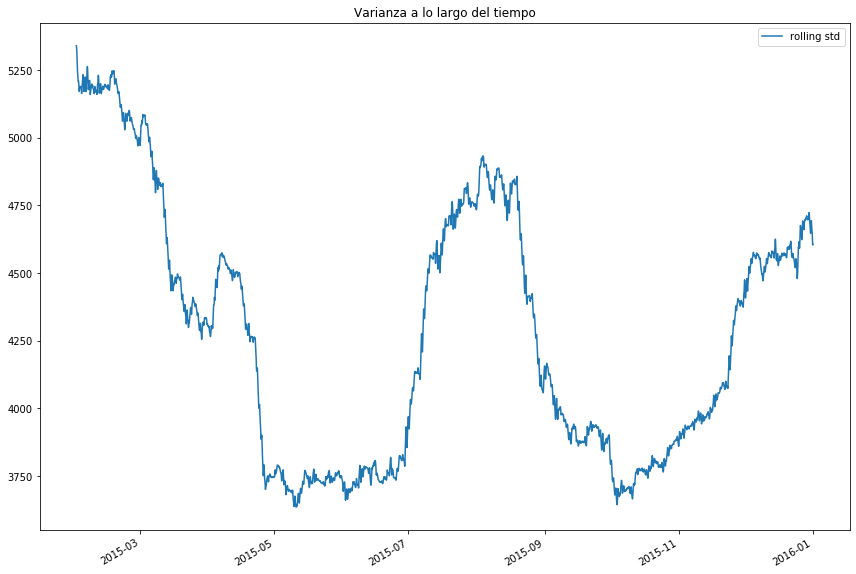

In [36]:
fig, ax = plt.subplots(figsize=(12, 9))

ax.plot(demand.index, demand.rolling(window=30*24*6).std(), label="rolling std");
ax.legend()

plt.tight_layout()
plt.title("Varianza a lo largo del tiempo")
fig.autofmt_xdate()

Como puede observarse, la varianza a principios, mitades y finales de año son mucho mayores, por lo que durante esta época se cometerá un mayor error probablemente a la hora de realizar predicciones.

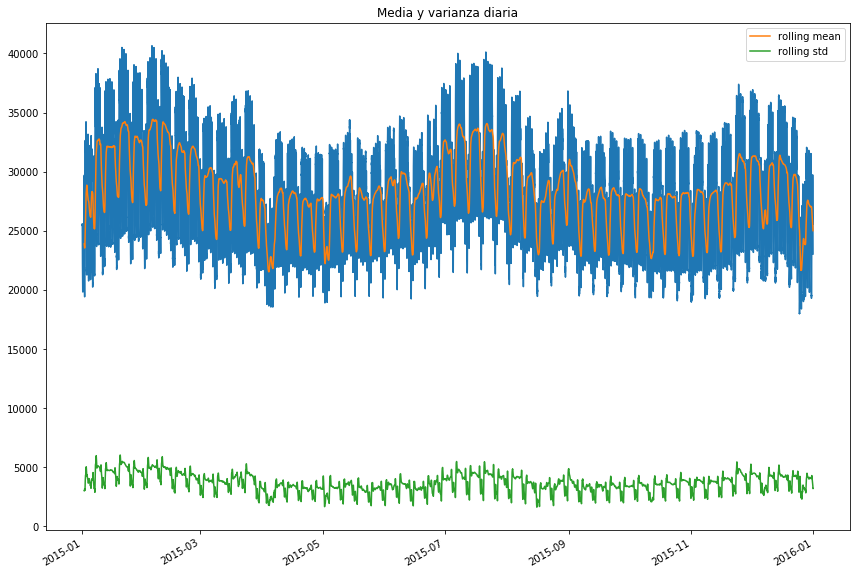

In [37]:
plot_rolling(demand, 24*6, "Media y varianza diaria")

Como se puede observar la media y la desviación típica es constante en el tiempo tomando una frecuencia mensual y constante con ciertas oscilaciones tomando un tamaño de ventana de un día.

A continuación, se mostrará la descomposición de la serie temporal en tendencia, estacionalidad y ruido.

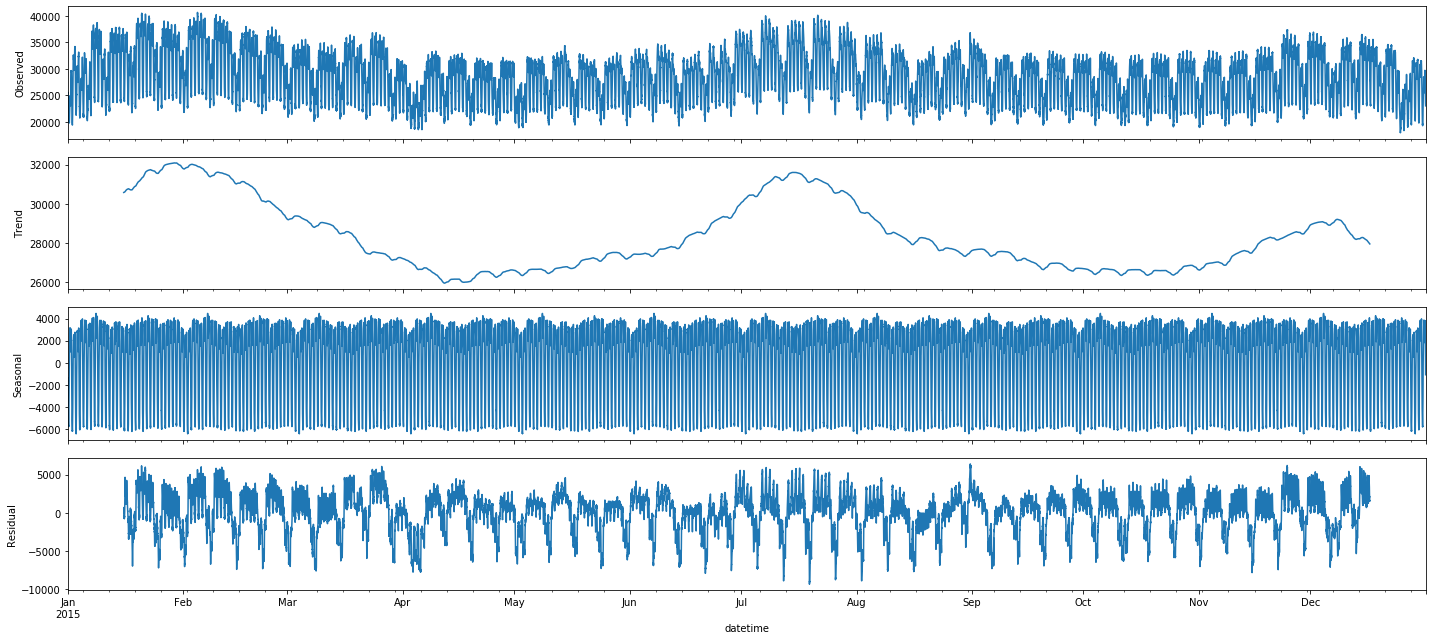

In [38]:
rcParams['figure.figsize'] = 20, 9
descomposed_demand = sm.tsa.seasonal_decompose(demand["demand"],freq=30*24*6) # Monthly frequency
figure = descomposed_demand.plot()
plt.show()

Con una frecuencia mensual asumida, se percibe que la tendencia sufre fluctuaciones, pero no se observa que exista una tendencia creciente o decreciente. Por otro lado, no se percibe que de
forma mensual exista una estacionalidad clara, aunque si se perciben ciertas bajadas que pueden dar lugar a ello. 
Analizando la gráfica residual se puede observar la aparición de valores con un error mayor al esperado, estos puntos son potenciales valores atípicos que se estudiarán posteriormente.

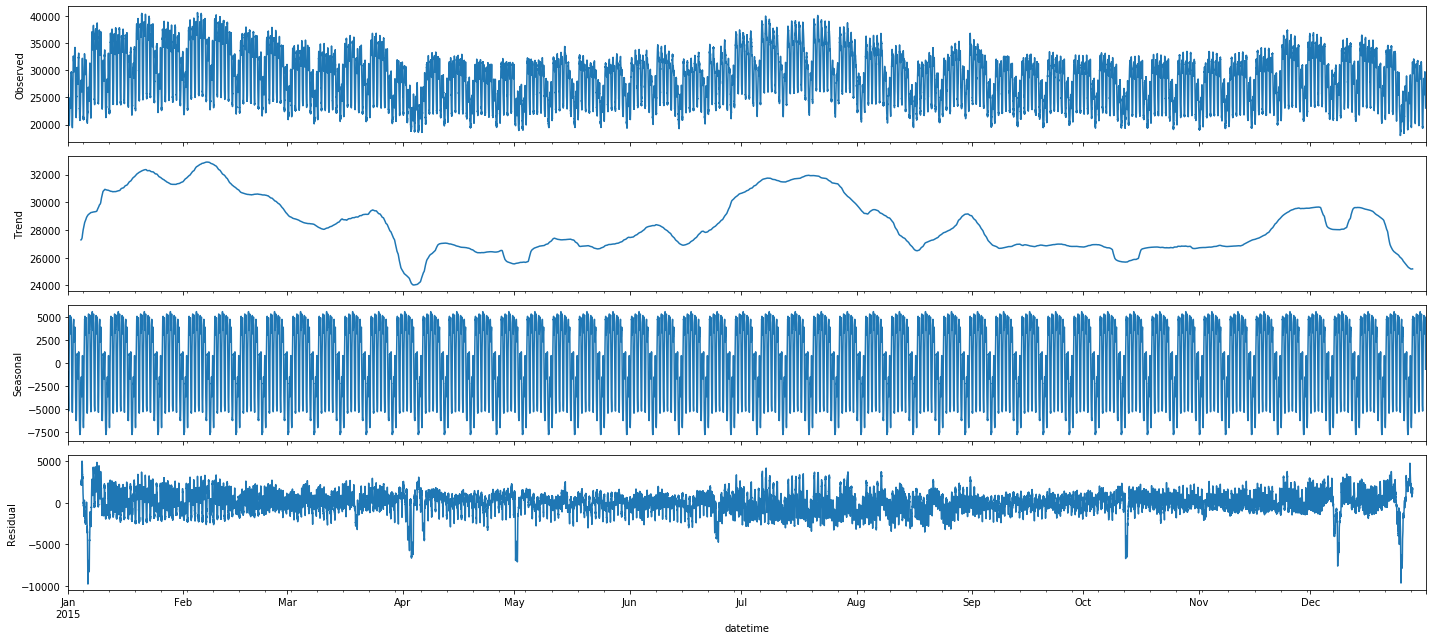

In [39]:
rcParams['figure.figsize'] = 20, 9
descomposed_demand = sm.tsa.seasonal_decompose(demand["demand"],freq=7*24*6) # Monthly frequency
figure = descomposed_demand.plot()
plt.show()

Estableciendo una frecuencia semanal la tendencia no muestra ningun incremento o decremento claro. Sin embargo, la estacionalidad puede observarse claramente 
definida en las fluctuaciones periódicas que presenta, por ello se puede decir que existe claramente una estacionalidad semanal en los datos. En cuanto al estudio de los residuos, se observa con mayor claridad los valores atípicos.

Por último y para terminar de asegurar que la serie temporal es estacionaria se realizará el test de Dickey-Fuller.

In [40]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(demand.demand, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = -21.669
P-value = 0.000
Critical values :
	1%: -3.4304745618132237 - The data is  stationary with 99% confidence
	5%: -2.8615950538210817 - The data is  stationary with 95% confidence
	10%: -2.566799303318103 - The data is  stationary with 90% confidence


Como se observa, realizando contraste de hipótesis se demuestra que no existen evidencia suficientes como para rechazar la hipótesis de estacionalidad, por
lo tanto podemos afirmar con suficiente confianza de que se trata de una serie estacionaria.

A continuación, se realizará un análisis más detallado de la serie temporal con el objetivo de observar patrones interesantes en esta.

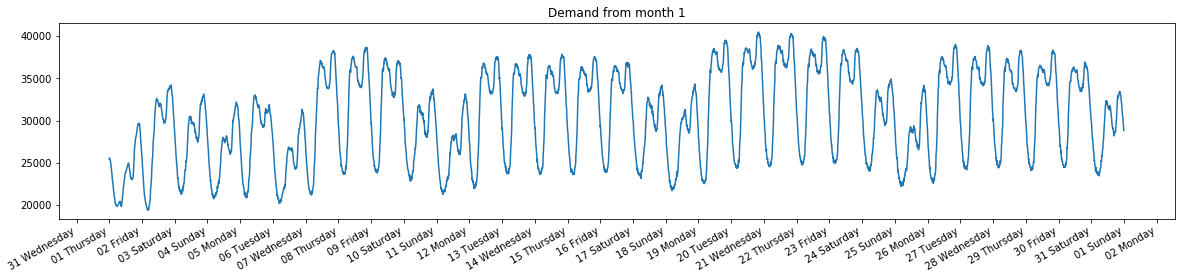

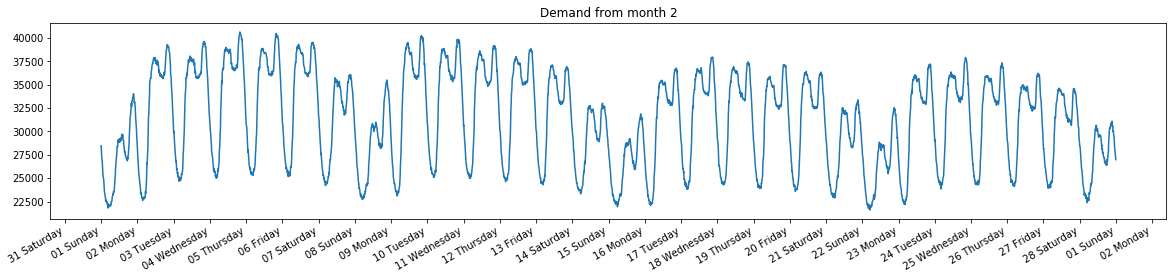

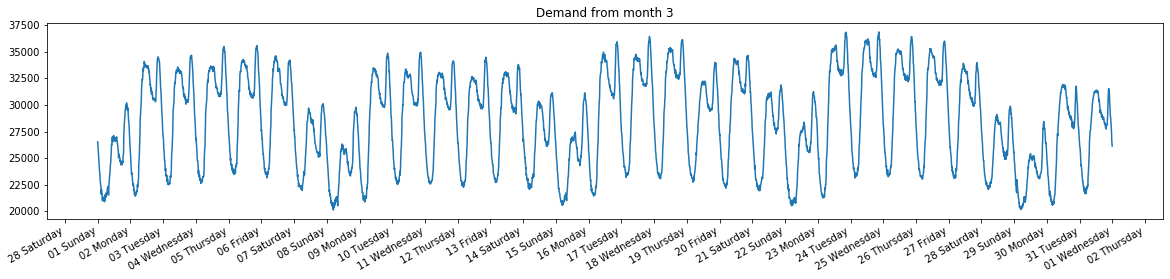

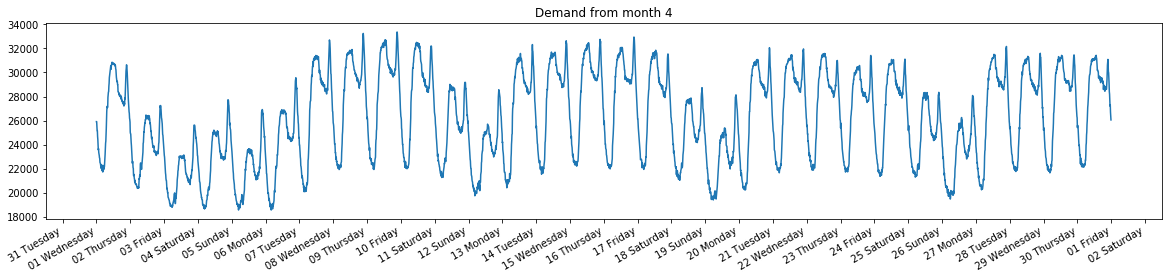

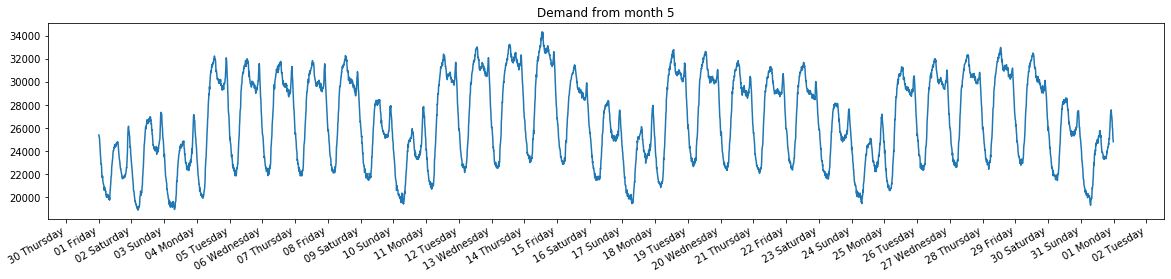

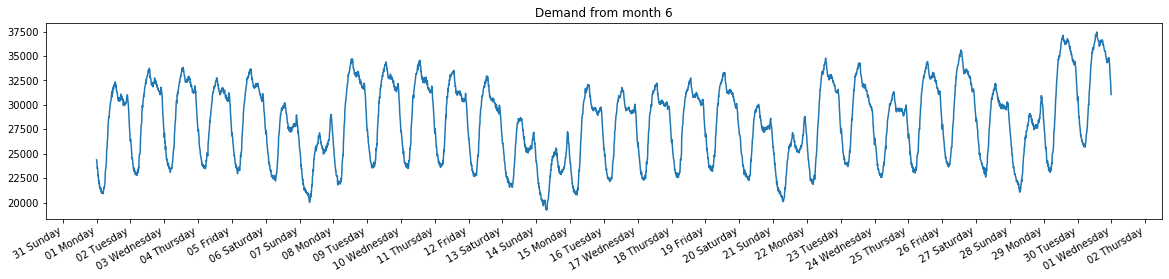

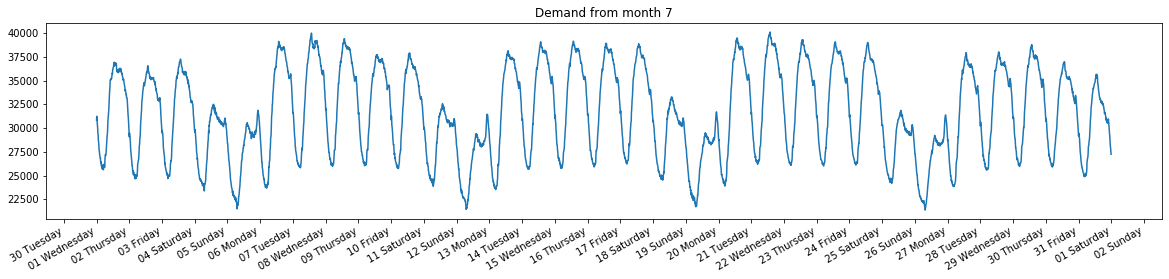

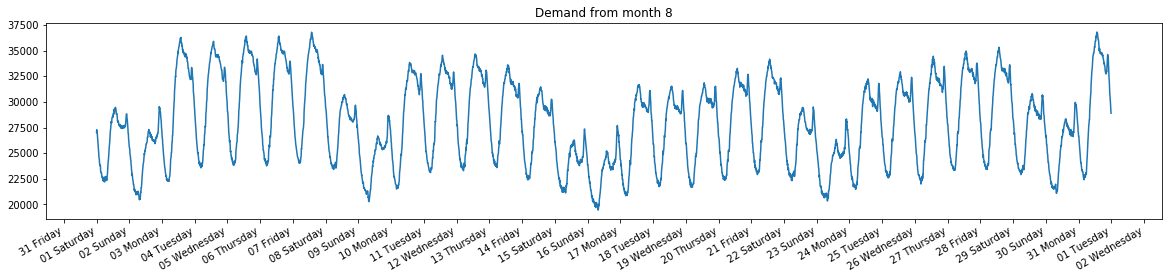

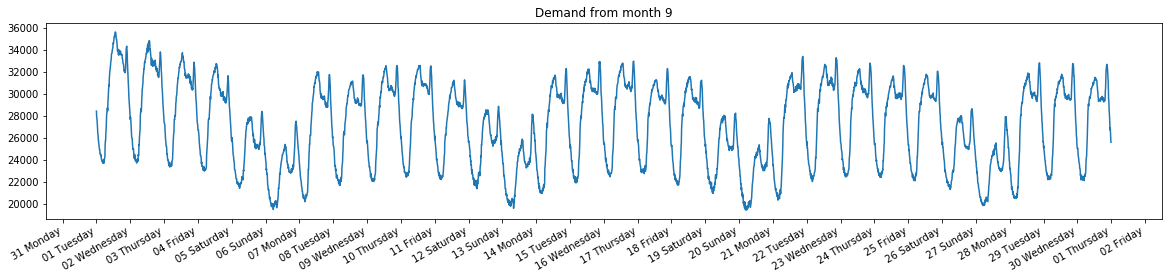

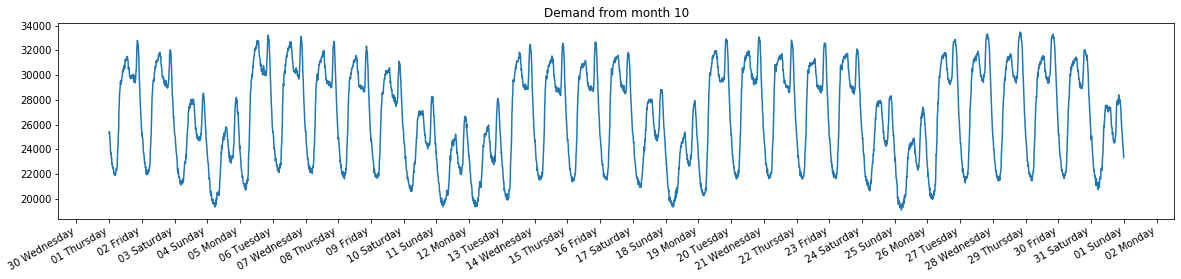

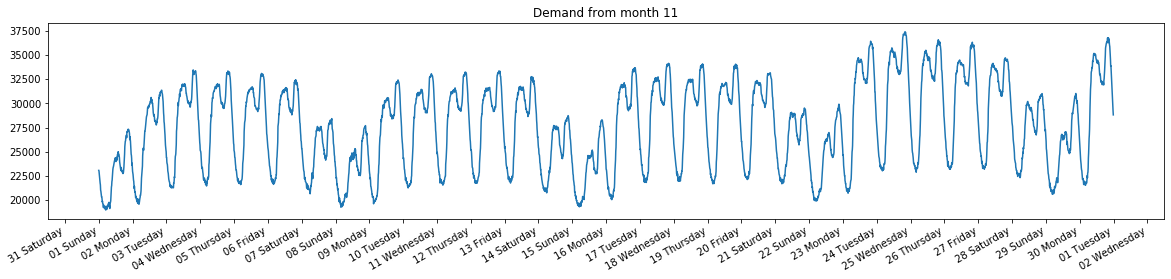

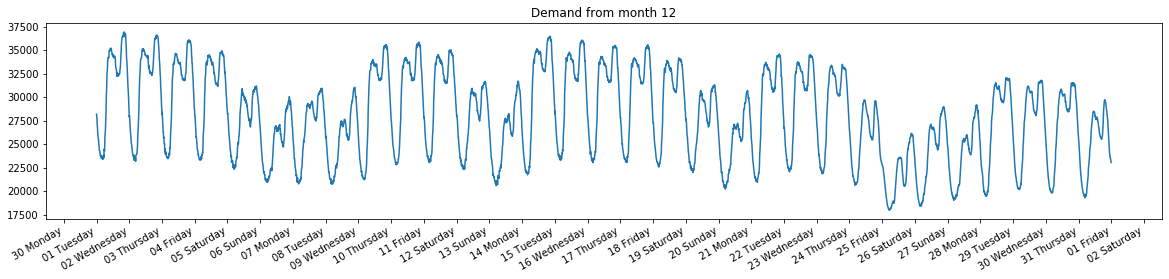

In [21]:
for month in range(1,13):

    plt.figure(figsize=(20,4))
    plt.title("Demand from month "+str(month))
    p = demand[demand.index.strftime("%m").astype(int)==month] 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %A'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(p.index, p["demand"])
    plt.gcf().autofmt_xdate()
    plt.show()

A través de esta serie de gráficas se puede observar como los meses poseen un comportamiento estacionario, es decir, siguen un mismo patrón. Se observa como en la mayoría de los casos, los días entre semana el consumo es alto decayendo los fines de semana. También puede apreciarse que los días festivos esta regla no se cumple, por ejemplo en el caso del día 8 y 9 de diciembre se observan unos valors menores a lo común coincidiendo con festividades españolas. Este comportamiento da a pensar que se trata de un lugar o edificio donde trabajen personas o una casa donde los fines de semana no se suele estar en casa.

Para poder analizar mejor el comportamiento de la serie temporal se visualizará una semana día a día para observar su evolución.

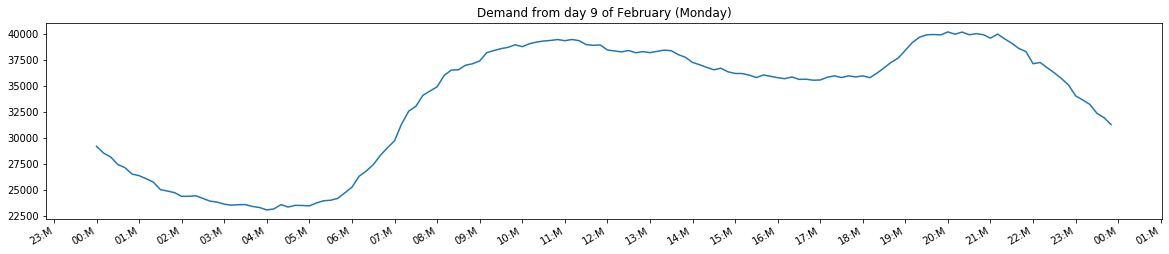

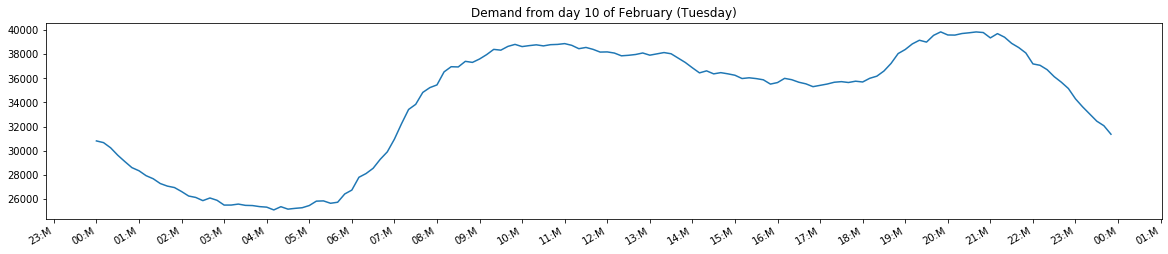

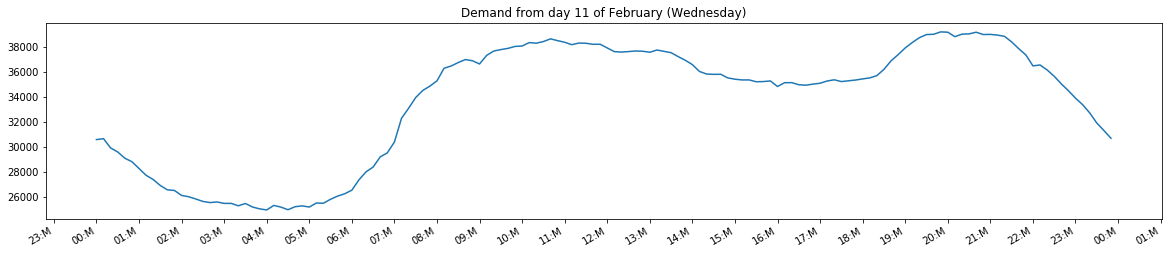

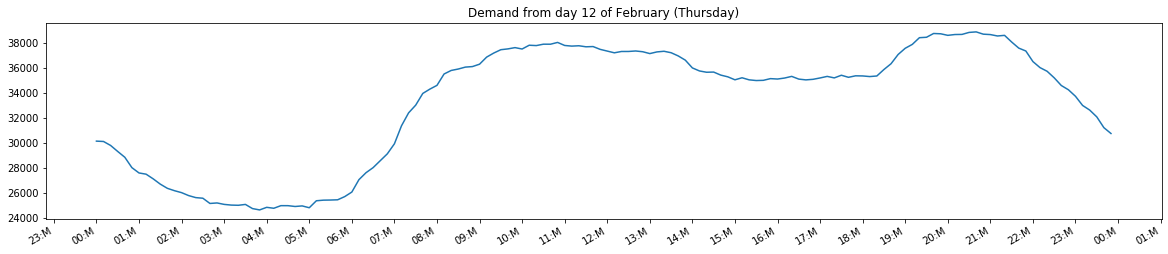

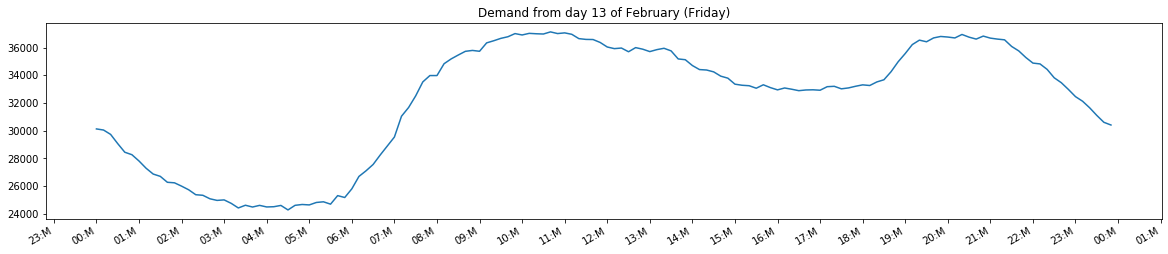

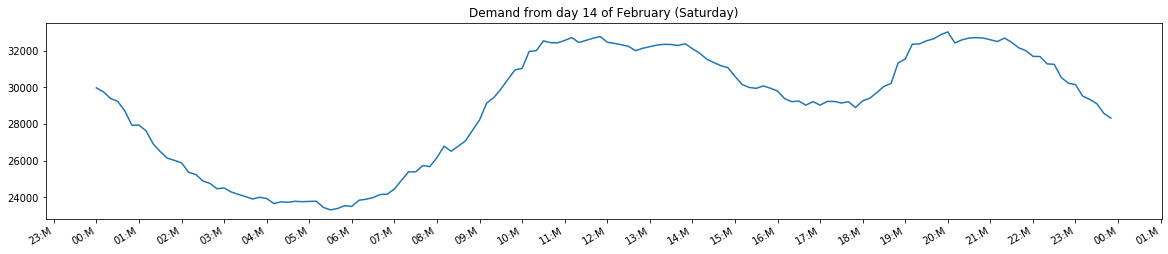

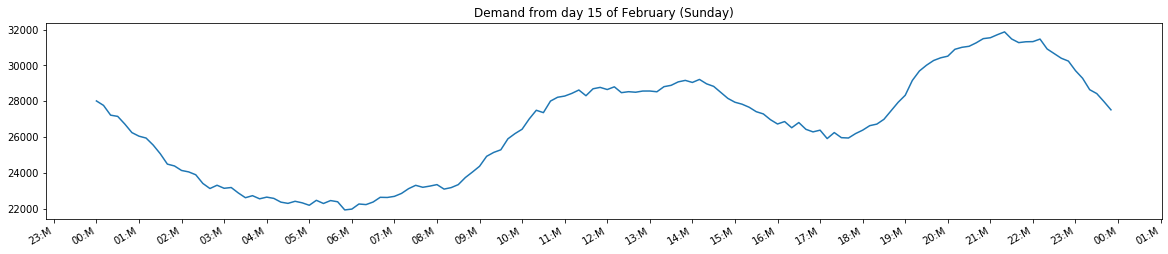

In [20]:
for d in range(9, 16):
    plt.figure(figsize=(20,4))

    p = demand[(demand.index.strftime("%m").astype(int)==2) & (demand.index.strftime("%d").astype(int)==d)]
    plt.title("Demand from day "+str(d) +" of February ("+p.index.strftime("%A")[0]+")")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.plot(p.index, p["demand"])
    plt.gcf().autofmt_xdate()
    plt.show()

Se ha escogido un día aparentemente normal para poder estudiar el comportamiento de la serie temporal de forma diaria. Se observa como 
la demanda cae hasta valores mínimos entre las 2 y 6 de la mañana, excepto en los fines de semana que se alarga hasta las 7-8 en el caso del sábado,
y hasta incluso 8-9 en el caso de los domingos. Existen dos máximos locales comprendidos entre las 10 am - 15 pm y las 7pm - 12pm. Este comportamiendo 
da a pensar que se trata de un hogar.

A continuación, Se mostrará la autocorrelación de los datos con el objetivo de descubrir qué intervalos de tiempo se encuentran mas correlados con el momento actual.

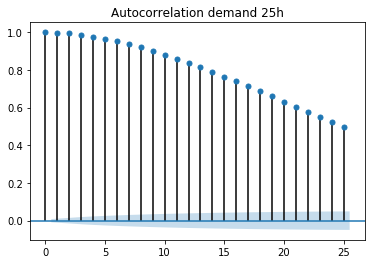

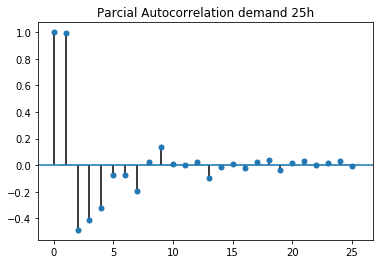

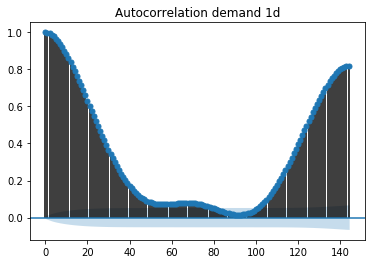

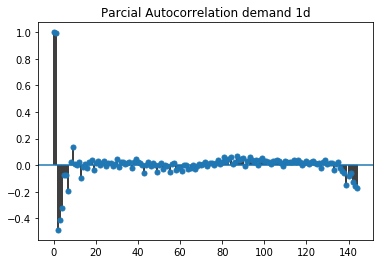

In [15]:
plot_acf(demand["demand"],lags=25,title="Autocorrelation demand 25h")
plt.show()

plot_pacf(demand["demand"],lags=25,title="Parcial Autocorrelation demand 25h")
plt.show()

plot_acf(demand["demand"],lags=6*24,title="Autocorrelation demand 1d")
plt.show()

plot_pacf(demand["demand"],lags=6*24,title="Parcial Autocorrelation demand 1d")
plt.show()

Mediante el estudio de la autocorrelación se pueden observar los valores temporales que están correlados, se observa que la correlación va decreciendo conforme más alejado en el tiempo se encuentra del dato actual. 
Por otro lado, la correlación parcial presentan mayores valores en los primeros valores y prácticamente cero en los otros periodos. Esto indica que un modelo de Autoregresión (AR) es sería adecuado donde el valor de predicción sera una conbinación de los valores pasados.

Si se realiza la autocorrelación con 24h a pasado se observa que conforme se acerca al mismo momento pero 24h en el pasado, la correlación y correlación parcial aumentan. Esto es debido a la estacionalidad de los datos, ya que los valores en periodos de tiempos similares poseerán características similares. Por ejemplo, la demanda a las 5 de la tarde un martes será similar a la del miércoles a la misma hora.

Por lo tanto nos encontramos tras una serie temporal con estacionalidad diaria y en el que pueden existir valores atípicos en épocas del año que coincidan con festivos o puentes y en el que los fines se comportan de distinta forma a los demás días de la semana.

Una vez analizado el comportamiento de los datos se estudiará la detección y obtención de outliers en más detalle.

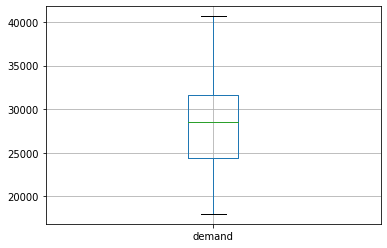

In [12]:
demand.boxplot()

Analizando un diagrama de cajas y bigotes, no se observan ningún valor atípico. Por lo tanto, es necesario estudiarlos mediante técnicas específicas para series temporales. Para ello, en primer lugar se usará la librería prophet con el que se creará unos límites en los que se esperan que se muevan los valores de la serie temporal a través de una predicción realizada sobre la serie temporal parecida a Auto-ARIMA.  

In [18]:
demand.columns = ["y", "ds"]
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(demand)

In [19]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [112]:
#pred.to_csv("prediction_prophet.csv")
pred

,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
ds,,,,,,,
2015-01-01 00:00:00,25962.409547,26220.739380,21618.125195,30753.078703,25459.0,0,0.000000
2015-01-01 00:10:00,25965.559463,25871.777018,21185.451254,30626.589626,25591.0,0,0.000000
2015-01-01 00:20:00,25968.709379,25532.484821,20621.434025,30216.173547,25531.0,0,0.000000
2015-01-01 00:30:00,25971.859295,25204.533205,20523.703256,29874.368141,25453.0,0,0.000000
2015-01-01 00:40:00,25975.009211,24889.269199,20515.167234,29347.412490,25329.0,0,0.000000
...,...,...,...,...,...,...,...
2015-12-31 23:10:00,28214.218937,29691.875438,24911.311360,34289.015397,NaN,-1,0.059785
2015-12-31 23:20:00,28214.328936,29326.348878,24326.300783,33742.470845,NaN,-1,0.035074
2015-12-31 23:30:00,28214.438935,28957.998986,24295.796722,33476.229041,NaN,-1,0.037971


Los resultados obtenidos de aplicar el modelo proporcionado por prophet interesantes son los límites en los que se consideran valores normales y si se considera anomalía.

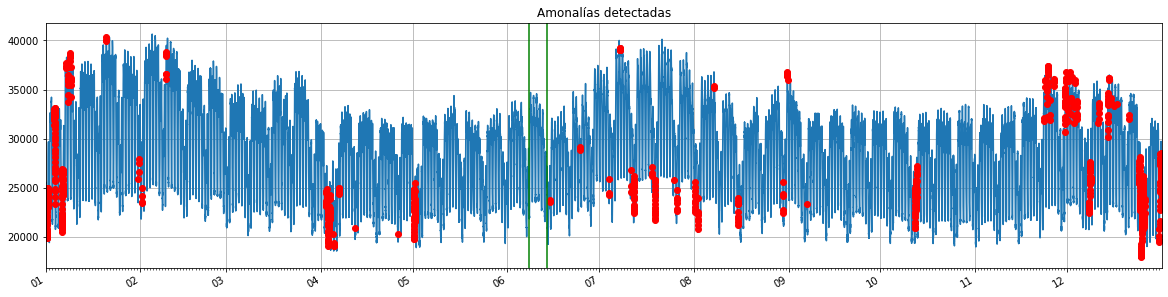

In [23]:
def plot_anomalies(forecasted):
    days = mdates.DayLocator()   # every year
    months = mdates.MonthLocator()  # every month
    months_fmt = mdates.DateFormatter('%m')
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot('ds', 'fact', data=forecasted[forecasted.anomaly==0])
    ax.plot('ds', 'fact', data=forecasted[forecasted.anomaly!=0], linewidth=0,color='red', marker='o')
    ax.axvline(datetime.datetime(2015, 6, 8), color='green')
    ax.axvline(datetime.datetime(2015, 6, 14), color='green')
    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)

    # round to nearest years.
    datemin = np.datetime64(demand['ds'][0], 'm')
    datemax = np.datetime64(demand['ds'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    plt.title("Amonalías detectadas")

              
plot_anomalies(pred)

Text(0.5, 1.0, 'Residuo de la serie temporal')

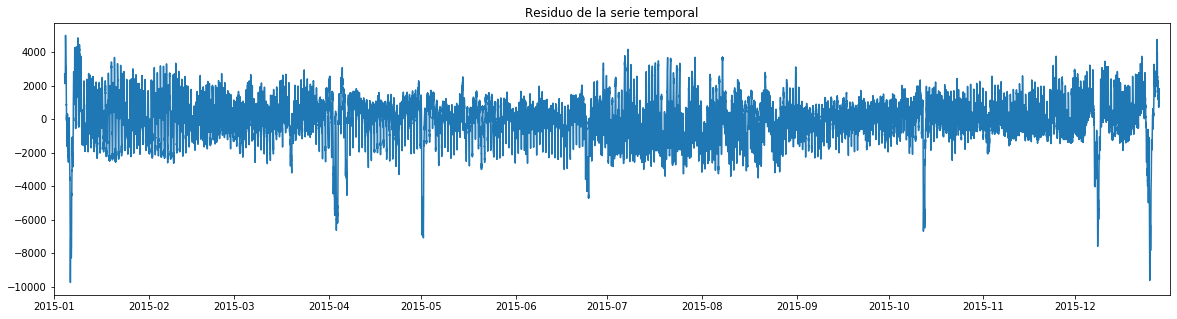

In [24]:
plt.figure(figsize=(20,5))
datemin = np.datetime64(demand['ds'][0], 'm')
datemax = np.datetime64(demand['ds'].iloc[-1], 'm') + np.timedelta64(1, 'm')
plt.xlim(datemin, datemax)
plt.plot(demand["ds"], descomposed_demand.resid)
plt.title("Residuo de la serie temporal")

Como se puede observar, las anomalías detectadas coinciden en gran medida con los valores de residuo de la serie temporal que poseían unos valores por encima o debajo de los valores normales. Estos casos anormales pueden deberse a días festivos como se ha estudiado anteriormente, por lo que es de esperar que otro año este comportamiento se repita. 
Los outliers detectados no se tratan de valores extremos fuera de lo común tal y como se ha visto en el diagrama de bigotes y cajas, se tratan valores que están fuera de lo esperado dentro de la distribución creada.

Para solucionar estos valores anómalos se podría sustituir estos valores por la media de la distribución, sin embargo, esta medida crearía situaciones donde habría un cambio brusco en los valores temporales. Es posible también realizar una interpolación tras la eliminación de estas variables, pero para ello sería necesario entrenar un modelo que sea capaz de tener en cuenta la estacionalidad de los datos sin crear cambios bruscos en los datos. Por ello, se mantendrán los datos originales sin ninguna modificación intentando que el modelo sea lo más robustos posible a este efecto.


### Modelado

Para la fase de modelado se ha escogido el modelo llamado Transformer publicado en el artículo "Attention is All you Need" en la conferencia internacional Neural Information Processing Systems de 2017. En este artículo se propone una nueva arquitectura de red neuronal llamada Transformer. Su funcionamiento se basa en varios conceptos descritos a continuación:


* Encoder-Decoder: Las arquitecturas encoder-decoder dividen la red neuronal en dos partes. En la primera (encoder) se proyecta la información a través de una serie de funciones que posteriormente se describirán. En la segunda (decoder) se toma la información obtenida del encoder y obtiene la salida de la red aplicando de nuevo funciones parecidas a la del encoder. Esta estructura es la usada actualmente en numerosas alquitecturas en problemas de predicción o NLP.

* Positional encoding: Esta función codifica la secuencia mediante funciones seno y coseno a diferentes frecuencias. LOs autores usaron esta forma de codificar debido a que ayudaría a permitir que se pudiera representar linearmente las posiciones de la secuencia en función de posiciones anteriores.

* Multi-Head Attention: El mecanismo de Attention original posndera los valores de la secuencia representando la "importancia" de esta. Este mecanismo va más allá y en lugar de aplicar una sola función de Attention realiza varias sobre la misma secuencia. 

* Masked Multi-Head Attention: Con el objetivo de evitar que posiciones futuras tengan influencia sobre posiciones pasadas, se aplica una máscara durante el cálculo de la función Attention.

* Eficiencia: Los autores afirman que la eficiencia es mayor que el uso de redes neuronales recurrentes al poder llegar a un mayor grado de paralelización.

Este modelo normalmente repite los elementos descritos anteriormente varias veces dando lugar a una red neuronal de gran tamaño.
El poder de este modelo reside en su capacidad de aprender sobre el contexto del problema en secuencias largas. Además se trata de una red más eficiente que las redes recurrentes.

Estructura: ![Feed-foward attention](https://miro.medium.com/max/2472/1*DIelATUu_zKd5eSqD8315Q.png)

In [53]:
scaler = MinMaxScaler()
demand_scaled = scaler.fit_transform(demand.demand[:"2015-06-08 00:00:00"].values.reshape(-1,1))
plt.figure()
demand_scaled.squeeze().shape

(22753,)

<Figure size 1440x648 with 0 Axes>

In [47]:
training_data = ListDataset(
    [{"start": demand.index[0], "target": demand_scaled.squeeze()}],
    freq = "10min"
)

Se realizará el entrenamiento del modelo con todos los datos hasta el 08-06-2015 con los siguiente hiperparámetros:

* Horizonte: 4 horas (24 salidas).
* Ventana: 4 horas (24 entradas).
* Épocas: 100.
* Learning Rate: 0.001.
* Optimizador: Adam.

La estructura no será lo más pequeña posible para evitar el tiempo excesivo de entrenamiento.

In [54]:
estimator = TransformerEstimator(freq="10min", prediction_length=24, context_length=24, trainer=Trainer(epochs=100, learning_rate=0.001))
predictor = estimator.train(training_data=training_data)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.59it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[0] Elapsed time 13.938 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.337687
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.75it/s, avg_epoch_loss=-.414]
INFO:root:Epoch[1] Elapsed time 13.334 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.414319
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  3.87it/s, avg_epoch_loss=-.83] 
INFO:root:Epoch[2] Elapsed time 12.909 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.829654
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.81it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[3] Elapsed time 13.137 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.086216
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00

100%|██████████| 50/50 [00:13<00:00,  3.79it/s, avg_epoch_loss=-3.07]
INFO:root:Epoch[73] Elapsed time 13.214 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-3.071053
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.85it/s, avg_epoch_loss=-3.06]
INFO:root:Epoch[74] Elapsed time 13.009 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-3.064464
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.82it/s, avg_epoch_loss=-3.03]
INFO:root:Epoch[75] Elapsed time 13.081 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-3.027840
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.83it/s, avg_epoch_loss=-3.02]
INFO:root:Epoch[76] Elapsed time 13.072 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-3.020432
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.84it/s, avg_epoch_loss=-3.05]
INFO:root:Epoch[77] Elapsed time 13.020 se

In [55]:
predictor.serialize(Path("./transformer/"))

In [8]:
predictor = Predictor.deserialize(Path("./transformer/"))

INFO:root:Using CPU


### Evaluación

Posteriormente se evaluará el modelo de tres formas distintas:

* Añadiendo los valores reales de ventana para predecir los horizontes de 4 horas cada 10 minutos de forma directa y evaluarlos junto a los valores reales para predecir hasta el 16 de junio.
* Añadiendo los valores reales de ventana para predecir los horizontes de 4 horas cada 4 horas de forma directa y evaluarlos junto a los valores reales para predecir hasta el 16 de junio.
* Añadir las predicciones como entrada de forma iterativa para predecir hasta el 16 de junio cada 4 horas.

#### Evaluación cada 4 horas:

========== METRICS ==========
RMSE: 598.9427709855364
MAE: 500.01230875651055
MAPE: 1.817723063485241


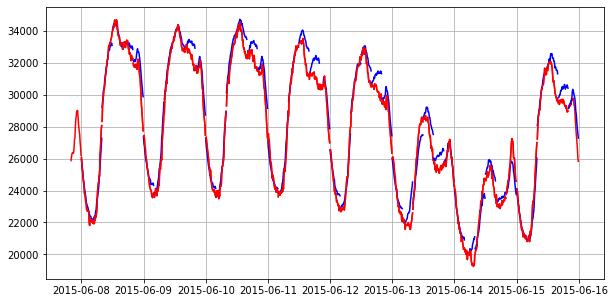

In [56]:
from gluonts.dataset.util import to_pandas
pd.plotting.register_matplotlib_converters()

from datetime import datetime  
from datetime import timedelta  
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

all_forecasts = []
all_timestamps = []
start_date = "2015-06-07 20:00:00"
start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
plt.figure(figsize=(10, 5))
global_rmse, global_mae, global_mape, global_corr = 0,0,0,0

iterations = 8*6
for i in range(iterations):
    
    test_scaled = scaler.transform(demand.demand[:str(start_datetime+timedelta(hours=4))].values.reshape(-1, 1))
    test_data = ListDataset(
        [{"start": demand.index[0], "target": test_scaled.squeeze()}],
        freq = "10min"
    )
    #print(test_scaled)

    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):

        timestamp = demand.index[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        test_timestamp = demand.index[demand.index.get_loc(str(start_datetime)):demand.index.get_loc(str(start_datetime+timedelta(hours=4)))]
        forecast = scaler.inverse_transform(np.mean(forecast.samples, axis=0).reshape(-1,1)).squeeze()
        real = demand.demand[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        plt.plot(demand.demand[demand.index.get_loc(str(start_datetime)):demand.index.get_loc(str(start_datetime+timedelta(hours=4)))], color='r')
        plt.plot(real, color='r')
        plt.plot(timestamp, forecast, color='b')
        
        global_rmse += rmse(real, forecast)
        global_mae += mae(real, forecast)
        global_mape += mape(real, forecast)
        #global_corr += corr(real, forecast)
    start_datetime = start_datetime + timedelta(hours=4)

print("========== METRICS ==========")
print("RMSE: "+str(global_rmse/iterations))
print("MAE: "+str(global_mae/iterations))
print("MAPE: "+str(global_mape/iterations))
#print("CORR: "+str(global_corr/iterations))
plt.grid(which='both')

#### Evaluación cada 10 minutos

In [61]:
from gluonts.dataset.util import to_pandas
pd.plotting.register_matplotlib_converters()

from datetime import datetime  
from datetime import timedelta  

all_forecasts = []
all_timestamps = []
start_date = "2015-06-07 20:00:00"
start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
iterations = 8*6*24
global_rmse, global_mae, global_mape, global_corr = 0,0,0,0
for i in range(iterations):
    
    test_scaled = scaler.transform(demand.demand[:str(start_datetime+timedelta(hours=4))].values.reshape(-1,1))
    test_data = ListDataset(
        [{"start": demand.index[0], "target": test_scaled.squeeze()}],
        freq = "10min"
    )

    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):

        #timestamp = demand.index[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        #test_timestamp = demand.index[demand.index.get_loc(str(start_datetime)):demand.index.get_loc(str(start_datetime+timedelta(hours=4)))]
        #forecast = np.mean(forecast.samples, axis=0)
        #plt.plot(test_timestamp, to_pandas(test_entry)[-24:], color='r')
        #forecast.plot(color='g')
        #plt.plot(timestamp, forecast, color='b')
        forecast = scaler.inverse_transform(np.mean(forecast.samples, axis=0).reshape(-1,1)).squeeze()
        real = demand.demand[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        
        global_rmse += rmse(real, forecast)
        global_mae += mae(real, forecast)
        global_mape += mape(real, forecast)

    start_datetime = start_datetime + timedelta(minutes=10)

print("========== METRICS ==========")
print("RMSE: "+str(global_rmse/iterations))
print("MAE: "+str(global_mae/iterations))
print("MAPE: "+str(global_mape/iterations))

========== METRICS ==========
RMSE: 626.0041757899643
MAE: 536.5699336440471
MAPE: 1.9585272535468954


Los resultados son parecidos a la aproximación cada 4 horas aun realizando más evaluaciones y acumulando más error. 

#### Evaluación iterativa

========== METRICS ==========
RMSE: 6721.118441996903
MAE: 6717.9824636953845
MAPE: 25.426833427225688


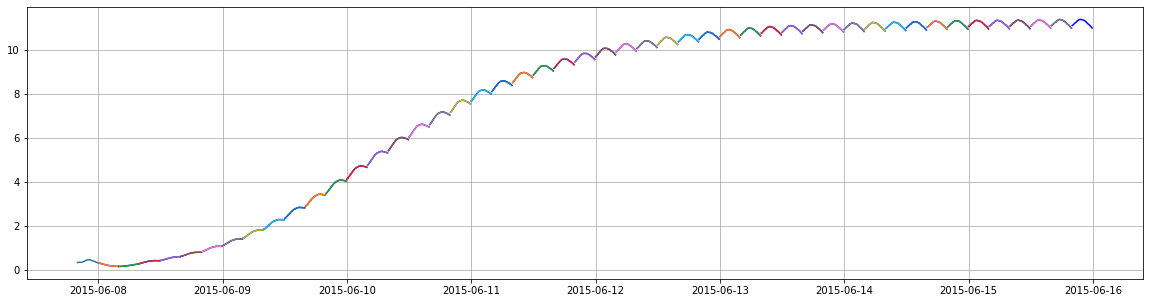

In [60]:
from gluonts.dataset.util import to_pandas
pd.plotting.register_matplotlib_converters()

from datetime import datetime  
from datetime import timedelta  

all_forecasts = []
all_timestamps = []
start_date = "2015-06-07 20:00:00"
start_datetime = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
test_scaled = scaler.transform(demand.demand[:str(start_datetime+timedelta(hours=4))].values.reshape(-1,1))
plt.figure(figsize=(20, 5))
global_rmse, global_mae, global_mape, global_corr = 0,0,0,0
for i in range(8*6):
    
    test_data = ListDataset(
        [{"start": demand.index[0], "target": test_scaled.squeeze()}],
        freq = "10min"
    )

    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):

        timestamp = demand.index[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        test_timestamp = demand.index[demand.index.get_loc(str(start_datetime)):demand.index.get_loc(str(start_datetime+timedelta(hours=4)))]
        forecast = np.mean(forecast.samples, axis=0)
        plt.plot(test_timestamp, to_pandas(test_entry)[-24:])
        #forecast.plot(color='g')
        plt.plot(timestamp, forecast, color='b')
        all_forecasts.extend(forecast)
        all_timestamps.extend(timestamp)
        test_scaled = forecast
        
        forecast = scaler.inverse_transform(forecast.reshape(-1,1)).squeeze()
        real = demand.demand[demand.index.get_loc(str(start_datetime+timedelta(hours=4))):demand.index.get_loc(str(start_datetime+timedelta(hours=8)))]
        
        global_rmse += rmse(real, forecast)
        global_mae += mae(real, forecast)
        global_mape += mape(real, forecast)
    
    start_datetime = start_datetime + timedelta(hours=4)
plt.grid(which='both')

print("========== METRICS ==========")
print("RMSE: "+str(global_rmse/iterations))
print("MAE: "+str(global_mae/iterations))
print("MAPE: "+str(global_mape/iterations))

Los resultados son diferentes mediante los dos tipos de aproximaciones de evaluación. Se puede observar como en el caso iterativo las predicciones tienen a crecer hasta estabilizarse, por lo que no ha sido capaz de captar la estacionalidad de los datos. Se espera que si la evaluación fuera cada 10 minutos este efecto se acrecentara y se produjera un error mayor aún.

### Conclusiones

La arquitectura usada proporciona buenos resultados cuando se le proporcionan datos reales. Además, se ha mostrado que realizando evaluaciones con periodicidades diferentes no ha presentando un cambio demasiado grande. Por lo tanto, en una aplicación real no se tendría que visualizar las predicciones cada 10 minutos, lo que podría no ser aceptable por un cliente o sistema. Es posible que se visualizaran las predicciones con una periodicidad mayor ahorrando tiempo de cómputo. 

Una evaluación realizada iterativamente no es una buena aproximación, es posible que otros tipos de redes como seq2seq produjeran mejores resultados de esta forma. Incluso abordarlo desde el punto de vista de un solo valor de horizonte podría haber resultado en mejores resultados de forma iterativa. Para abordar unos buenos resultados con esta arquitectura, sería necesario ajustar el intervalo de tiempo que se quiere predecir al horizonte deseado con el objetivo de evitar la aproximación iterativa. 

Otra posible solución podría ser crear varios modelos con horizontes de 4 horas. El perido de tiempo que se desea predecir, se dividiría en intervalos de 4 horas y se le asignaría un modelo que predeciría dicho intervalo. Sin embargo, esto multiplicaría el tiempo de entrenamiento y evaluación.